In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from datetime import date
import holidays
from fbprophet import Prophet

1) После установки библиотек( они будут пополняться при надобности),мы считаем данные и первично их осмотрим,приведём их в удобный вид.
Ну и немного настроек графика.

In [2]:
df = pd.read_csv('Analyst_task251021.csv',sep = ';')

In [3]:
df.head()

,trn_month,trn_day,regionname,unitid,newclient,platformid,clientfirstpurchaseproduct,ordertype,productid,categoryid,sizenumber,response
0,10,22,Московская область,200,0,2.0,0,доставка,15016,напитки,0.4,6
1,5,11,Уральский ФО,627,0,0.0,0,самовывоз,15016,напитки,0.4,7
2,10,10,Дальневосточный ФО,111,0,1.0,1,доставка,15025,закуски,260.0,7
3,3,18,Приволжский ФО,1156,1,NaN,0,доставка,15023,десерты,16.0,7
4,3,5,Санкт-Петербург,448,0,NaN,1,доставка,3100,пицца,30.0,6


In [4]:
df['trn_month'] = df.trn_month.astype(str) 
df['trn_day'] = df.trn_day.astype(str)
df['date'] = df.trn_month + '-' + df.trn_day + '-' + '2021'
df['date'] = pd.to_datetime(df.date)
df['trn_month'] = df.trn_month.astype(int) 
df['trn_day'] = df.trn_day.astype(int)

Тут мы создали новый столбец типа "datetime64[ns]" для дальнейшего удобства.
Почему именно 2021? А не 1900,2020? Во - первых это было недавно и мне так легче, во - вторых судя по активностям доставок в данных и выходным в 2021 

In [5]:
df.dtypes # Да,он просто чудесно вписался

trn_month                              int64
trn_day                                int64
regionname                            object
unitid                                 int64
newclient                              int64
platformid                           float64
clientfirstpurchaseproduct             int64
ordertype                             object
productid                              int64
categoryid                            object
sizenumber                           float64
response                               int64
date                          datetime64[ns]
dtype: object

По всей видимости у нас 3 вида платформы( 1- андройд,2 - ios и т.д.), неопознанная платформа теперь будет равна - 3

In [6]:
df['platformid'] = df.platformid.fillna(3) 

2) Само задание.

Часть 1
- Что происходит с оценкой показателя со временем
- Оценить изменения во времени с т.з. статистической значимости  (построить доверительные интервалы/проверить гипотезы)
- Есть ли какие-то региональные особенности


Поскольку дословно , основная метрика это -  "Мы, как бизнес, усредняем полученные оценки за момент времени (неделя, месяц), и это является для нас целевой метрикой." То для начала мы посмотрим среднюю оценку нашей выборки по месяцам.


In [7]:
ddf = df.groupby('trn_month',as_index = False)\
  .agg({'response':'mean'})\
  .sort_values('trn_month',ascending = True)
se_all = []

In [8]:
def sample(df,date):
    sample_real = df.query(f'trn_month == {date}').response
    se = sample_real.std() / (len(sample_real) ** 0.5)
    return sample_real.mean() + 1.96 * se , sample_real.mean() - 1.96 * se, 1.96 * se

Очень удобная( на мой взгляд ) ф-ия для вычесления ДИ в данном датафрейме.

In [9]:
v_DI = []
n_DI = []
for i in range(10):
    print(f'Доверительный интервал для {i+1} месяца!')
    print(sample(df,i+1))
    v_DI.append(sample(df,i+1)[0])
    n_DI.append(sample(df,i+1)[1])
    se_all.append(sample(df,i+1)[2])
ddf['upper_bound'] = pd.Series(v_DI)
ddf['lower bound'] = pd.Series(n_DI) 
se_all = pd.Series(se_all) # Этот костыль нам для визуализации =)

Доверительный интервал для 1 месяца!
(6.361960407726321, 6.338635577217217, 0.011662415254551662)
Доверительный интервал для 2 месяца!
(6.329728184996617, 6.303667337391443, 0.013030423802587359)
Доверительный интервал для 3 месяца!
(6.3365898416409285, 6.313795468550926, 0.011397186545001443)
Доверительный интервал для 4 месяца!
(6.3641332105365676, 6.343706912445755, 0.01021314904540652)
Доверительный интервал для 5 месяца!
(6.315058664036476, 6.296811921518319, 0.009123371259078016)
Доверительный интервал для 6 месяца!
(6.284610866917721, 6.265738762799329, 0.0094360520591958)
Доверительный интервал для 7 месяца!
(6.235987819867949, 6.2143985625714535, 0.010794628648247475)
Доверительный интервал для 8 месяца!
(6.211488010186988, 6.190347442495922, 0.010570283845533091)
Доверительный интервал для 9 месяца!
(6.223591107541662, 6.201636294131136, 0.010977406705262791)
Доверительный интервал для 10 месяца!
(6.210857379413685, 6.189128545248067, 0.010864417082808699)


Если доверительный интервал средней оценки в N месяце не пересекается с доверительным интервалом во N+1 месяце , это означает что изменения статистически значимы.

In [14]:
ddf

,trn_month,response,upper_bound,lower bound
0,1,6.350298,6.361960,6.338636
1,2,6.316698,6.329728,6.303667
2,3,6.325193,6.336590,6.313795
3,4,6.353920,6.364133,6.343707
4,5,6.305935,6.315059,6.296812
5,6,6.275175,6.284611,6.265739
6,7,6.225193,6.235988,6.214399
7,8,6.200918,6.211488,6.190347
8,9,6.212614,6.223591,6.201636
9,10,6.199993,6.210857,6.189129


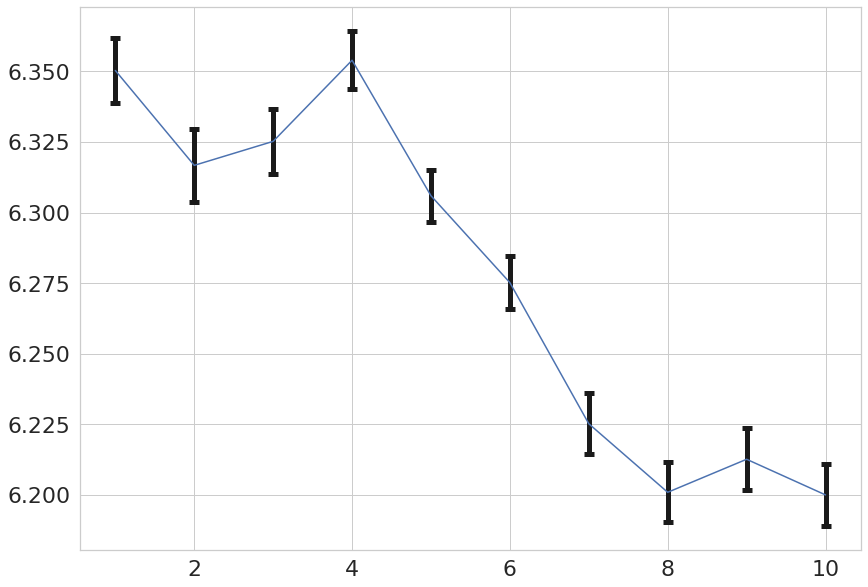

In [15]:
x = ddf.trn_month
y = ddf.response
plt.errorbar(x, y, yerr=se_all,
    ecolor='k', elinewidth=5, capsize=5, capthick=5)
sns.set(
       font_scale = 2,
        style      = 'whitegrid',
        rc         = {'figure.figsize':(14,10)})
plt.show()

Почему же показатель уменьшается со временем? Смотря на график мы понимаем что самое активное снижение было с 4 по 7 месяц включительно, изучим происходящее в данных месяцах

In [16]:
df_1 = df.query('trn_month >= 4 and trn_month <= 7')
df_2 = df.query('trn_month < 4')

In [18]:
df_1.query('ordertype == "ресторан"').groupby(['regionname','ordertype'],as_index = False)\
.agg({'response':'count'})\
.sort_values('response',ascending= False)

,regionname,ordertype,response
4,Приволжский ФО,ресторан,8072
2,Москва,ресторан,4937
9,Уральский ФО,ресторан,4568
5,Санкт-Петербург,ресторан,3934
3,Московская область,ресторан,3881
11,Южный ФО,ресторан,3723
8,Сибирский ФО,ресторан,3264
10,Центральный ФО,ресторан,3261
6,Северо-Западный ФО,ресторан,3133
0,Дальневосточный ФО,ресторан,2480


In [21]:
df_2.query('ordertype == "ресторан"').groupby(['regionname','ordertype'],as_index = False)\
.agg({'response':'count'})\
.sort_values('response',ascending= False)

,regionname,ordertype,response
5,Северо-Западный ФО,ресторан,313
3,Приволжский ФО,ресторан,90
1,Москва,ресторан,30
4,Санкт-Петербург,ресторан,24
2,Московская область,ресторан,15
0,Ленинградская область,ресторан,6


In [22]:
df.groupby(['regionname','ordertype'],as_index = False)\
  .agg({'response':'mean'})\
  .sort_values('response',ascending = False) 

,regionname,ordertype,response
24,Северо-Кавказский ФО,самовывоз,6.744000
12,Не определен,доставка,6.562500
33,Центральный ФО,самовывоз,6.518828
15,Приволжский ФО,самовывоз,6.477152
36,Южный ФО,самовывоз,6.474061
27,Сибирский ФО,самовывоз,6.457906
30,Уральский ФО,самовывоз,6.445019
2,Дальневосточный ФО,самовывоз,6.427734
23,Северо-Кавказский ФО,ресторан,6.426020
21,Северо-Западный ФО,самовывоз,6.420530


Я разделил датафрейм на два, первый df_1(4 - 7 месяц включительно) и второй df_2(1,2,3 месяцы). Мы можем наблюдать просто колоссальную разницу в цифрах, могу предположить что именно начиная с 4 - го месяца начали активно собирать оценки из ресторанов, т.к. мы наглядно видим например Москва за 1 - 3 месяц - 30 оценок,Москва 4 - 7 месяц - 4937.
Так же далее я на примере всего датафрейма показал - самые высокие оценки в среднем - доставка и самовывоз, оценки из ресторана - меньше.
Мой вывод следующий, либо оценки из ресторанов начали более массово собираться с 4 го месяца и оттого и упала оценка, либо открытие большого кол-ва ресторанов.
Почему оценка в ресторане меньше чем доставка, моё мнение как пользователя:
1) в случае с доставкой мы оцениваем как правило качество продукции( ну в нём то мы уверены) и некоторые моменты связанные с курьером
2) в случае же с рестораном мы оцениваем всё в совокупности, начиная от сервиса, заканчивая чистотой зала, полов иииии только потом качеством продукции